# <u>Submission instructions</u>
### Submission in pairs unless otherwise authorized
<ul style="font-size: 17px">
<li> This notebook contains all the questions. You should follow the instructions below.</li>
<li> Solutions for both theoretical and practical parts should be written in this notebook</li>
</ul>

<h3> Moodle submission</h3>


<p style="font-size: 17px">
You should submit three files:
</p>
<ul style="font-size: 17px">
<li>IPYNB notebook:
  <ul>
  <li>All the wet and dry parts, including code, graphs, discussion, etc.</li>
  </ul>
</li>
<li>PDF file:
  <ul>
  <li>Export the notebook to PDF. Make sure that all the cells are visible.</li>
  </ul>
</li>
</ul>
<p style="font-size: 17px">
All files should be in the following format: "HW2_ID1_ID2.file"
<br>
Good Luck!
</p>

# Question 1 - Generalizrtion and Overfit (30 pt)

<p style="font-size: 17px"> In this exercise, we will demonstrate overfitting to random labels.The settings are the following:
<ul style="font-size: 17px">
<li> Use the MNIST dataset.
<li> Work on the first 128 samples from the training dataset.
<li> Fix the following parameters:
    <ul>
        <li> Shuffle to False.
        <li> Batch size to 128.
    </ul>
<li> Generate random labels from Bernoulli distribution with a probability of $\frac{1}{2}$. I.e.,each sample is assigned a random label which is zero or one.
</ul>

<p style="font-size: 17px">
Show that by using a Fully Connected netwrok and cross-entropy loss, you are able to achieve a loss value of ~0 (the lower the better).
Plot the accuracy and loss convergence for this data and the test data as a function of epochs.
What is the accuracy value of the test data? Explain
</p>

Epoch [1/100], Train Loss: 0.7078, Test Loss: 0.6807, Train Accuracy: 42.19%, Test Accuracy: 57.03%
Epoch [2/100], Train Loss: 0.6779, Test Loss: 0.6871, Train Accuracy: 57.81%, Test Accuracy: 57.03%
Epoch [3/100], Train Loss: 0.6746, Test Loss: 0.6905, Train Accuracy: 57.81%, Test Accuracy: 57.03%
Epoch [4/100], Train Loss: 0.6666, Test Loss: 0.6968, Train Accuracy: 57.81%, Test Accuracy: 57.03%
Epoch [5/100], Train Loss: 0.6624, Test Loss: 0.7005, Train Accuracy: 57.81%, Test Accuracy: 57.03%
Epoch [6/100], Train Loss: 0.6538, Test Loss: 0.7054, Train Accuracy: 57.81%, Test Accuracy: 57.03%
Epoch [7/100], Train Loss: 0.6468, Test Loss: 0.7104, Train Accuracy: 57.81%, Test Accuracy: 57.81%
Epoch [8/100], Train Loss: 0.6374, Test Loss: 0.7168, Train Accuracy: 60.16%, Test Accuracy: 58.59%
Epoch [9/100], Train Loss: 0.6287, Test Loss: 0.7240, Train Accuracy: 67.19%, Test Accuracy: 57.03%
Epoch [10/100], Train Loss: 0.6187, Test Loss: 0.7319, Train Accuracy: 68.75%, Test Accuracy: 57.81%

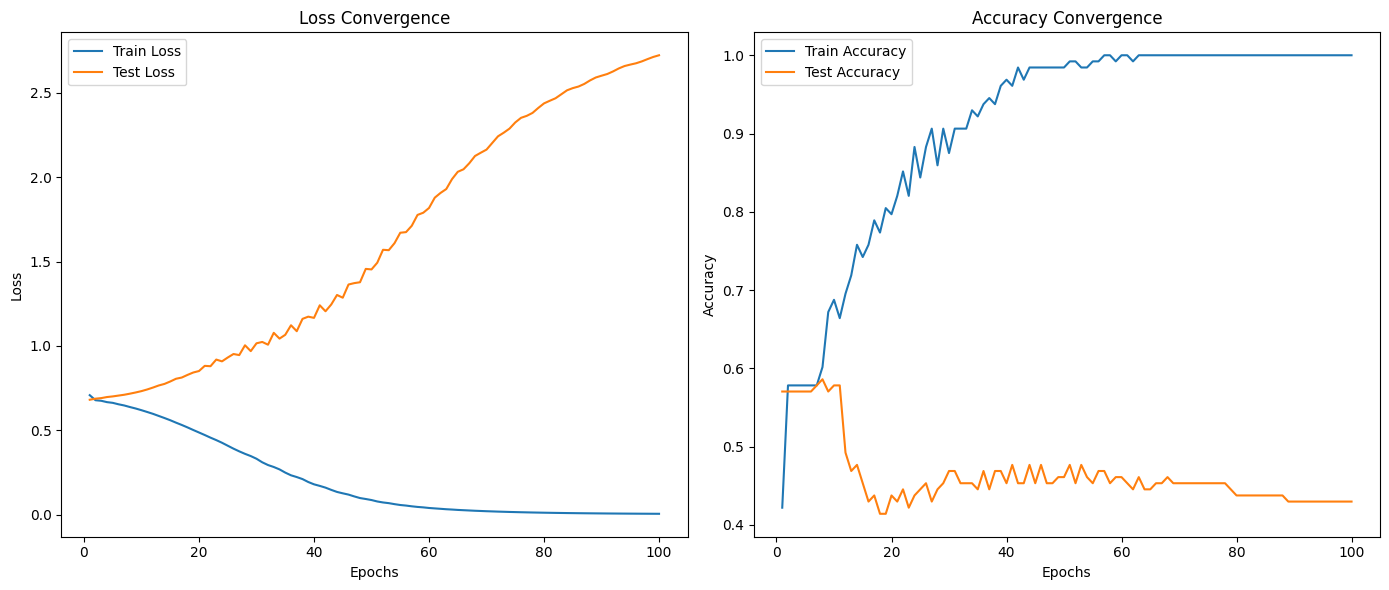

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
to_pil = transforms.ToPILImage()  # Convert Tensor to PIL Image
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Take only the first 128 samples for both train and test datasets
train_images = mnist_train.data[:128]
train_labels = torch.randint(0, 2, (128,))  # Random binary labels for training
test_images = mnist_test.data[:128]
test_labels = mnist_test.targets[:128]%2  # Original labels for testing

# Create a custom dataset to handle these
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = to_pil(image)  # Convert Tensor to PIL Image
            image = self.transform(image)
        return image, label

# Create training and testing datasets
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define a Fully Connected Network
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Binary classification
        )

    def forward(self, x):
        return self.layers(x)

# Initialize the model, loss function, and optimizer
model = FullyConnectedNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation loop
epochs = 100
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    # Training
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_losses.append(total_loss)
    train_accuracies.append(correct / total)

    # Evaluation
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Calculate test accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    test_losses.append(total_loss)
    test_accuracies.append(correct / total)

    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
          f"Train Accuracy: {100 * train_accuracies[-1]:.2f}%, Test Accuracy: {100 * test_accuracies[-1]:.2f}%")

# Plot the results
plt.figure(figsize=(14, 6))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Convergence")
plt.legend()

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Convergence")
plt.legend()

plt.tight_layout()
plt.show()


The test accuracy, as shown in the "Accuracy Convergence" plot, stabilizes at around 40% after initial fluctuations. This behavior is expected due to the following reasons:
1. Random Labels in the Training Data: The training dataset has been assigned random binary labels (0 or 1), which contain no meaningful patterns.
2. Original Labels in the Test Data: The test dataset retains the original binary labels derived from the MNIST dataset. Since the model was trained on random labels, it cannot generalize to the test dataset.
3. Overfitting:  The model achieves nearly 100% training accuracy as it memorizes the random labels. However, this overfitting leads to poor performance on unseen test data, resulting in a low test accuracy (~40%).

Conclusion: 
When trained on random labels, the model essentially guesses when applied to the test set. <br>With binary classification, a baseline accuracy of 50% is expected for random guessing.
The observed test accuracy (~40%) is close to this baseline and reflects the inability of the model to generalize.

********************

<h1> Question 2 - Sentiment Analysis - Classification (70 pt)</h1>

### Exercise
<p style="font-size: 17px">
The goal of this exercise is to get familiar with recurrent neural networks. 
<br><br>
The field of detecting which emotion is represented in a text is developing and being
studied due to its usefulness. For example, detecting if a review is positive or
negative and more.
<br><br>
In this exercise, you will detect the emotion of a sentence. You should get at least 47% accuracy on the test set.
<br><br>
You should
<ul style="font-size: 17px">
  <li> Try different model architectures - Vanilla RNN and Gated model (GRU/LSTM)</li>
  <li> Use different optimization and regularization methods </li>
  <li> Try different combinations of hyperparamters</li>
</ul>
</p>

<br>

### Data

<p style="font-size: 17px">
The data is a csv file containing tweets and their labels according to the emotion –
{happiness, sadness, neutral}. Every row in the file (except for the header) is an
example. 
<br>
Examples: (Notepad++ view)
<ul style="font-size: 17px">
  <li> happiness,Welcome @doeko ! Really glad to know you here. Your products rox man</li>
  <li> sadness,Disappointment really sucks! I'm getting used to it.</li>
  <li> neutral,I just want to Sleep.</li>
</ul>
<p style="font-size: 17px">
You have a train file – "trainEmotions.csv" and a test file – "testEmotions.csv". Both files can be found in the "HW2_data.zip" file.
</p>

### Tips

<p style="font-size: 17px">
Instead of using One-hot embeddings for the data, use <code>nn.Embedding</code>. 
You also might add "Start Of Sentence" (SOS) and "End Of Sentence" (EOS) embeddings.
</p>

### a) EDA (10 pt)

<p style="font-size: 17px">
Explore and analyze your data. Explain your data cleaning and processing pipeline.
</p>

C:\Users\shaha\AppData\Local\Temp\ipykernel_19568\663106877.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=train_data, x='emotion', order=train_data['emotion'].value_counts().index, palette="viridis")


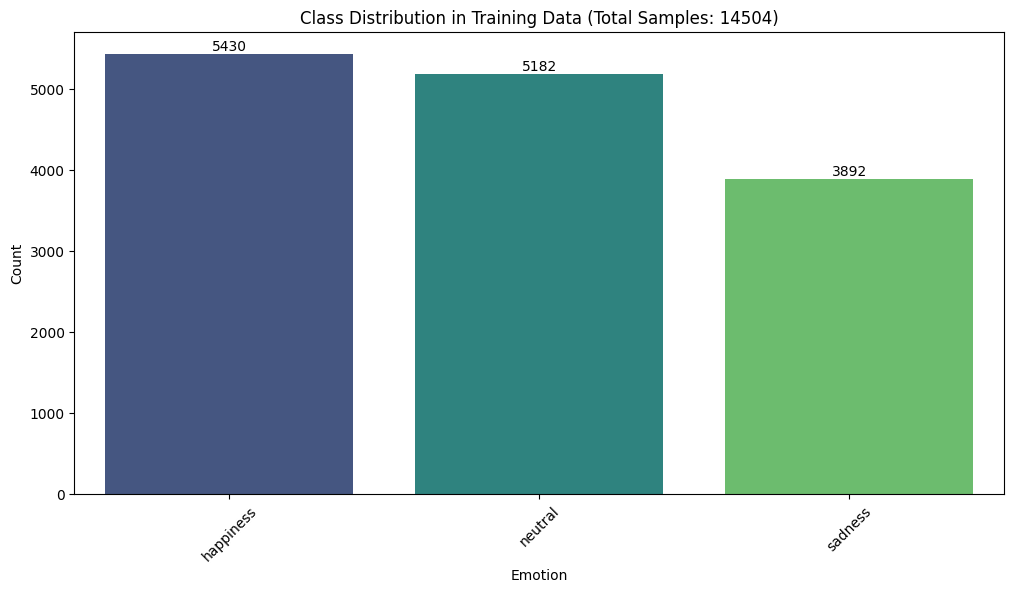

C:\Users\shaha\AppData\Local\Temp\ipykernel_19568\663106877.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=test_data, x='emotion', order=test_data['emotion'].value_counts().index, palette="magma")


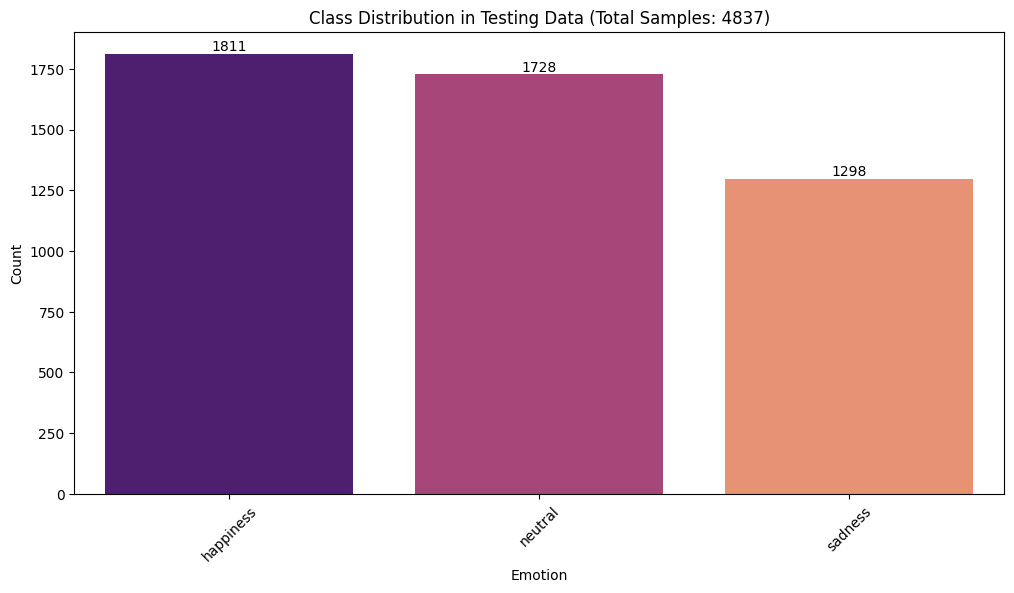

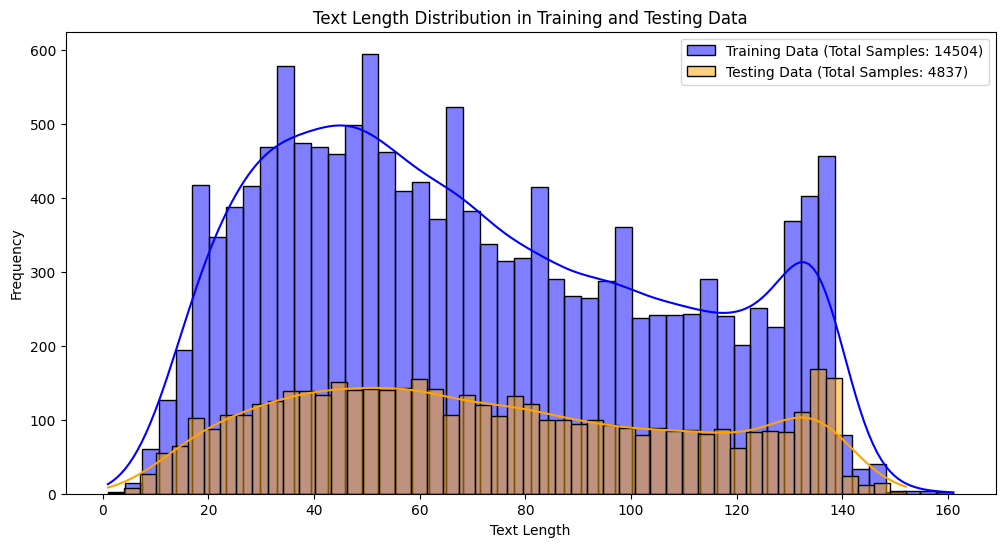

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
train_data = pd.read_csv(r'trainEmotions.csv', header=0, names=['emotion', 'content'])
test_data = pd.read_csv(r'testEmotions.csv', header=0, names=['emotion', 'content'])

# Drop rows with missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Function to add counts to the bar plots
def add_counts(ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=10, color='black', xytext=(0, 5), 
                    textcoords='offset points')

# Class Distribution in Training Data
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=train_data, x='emotion', order=train_data['emotion'].value_counts().index, palette="viridis")
add_counts(ax)
plt.title(f"Class Distribution in Training Data (Total Samples: {len(train_data)})")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Class Distribution in Testing Data
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=test_data, x='emotion', order=test_data['emotion'].value_counts().index, palette="magma")
add_counts(ax)
plt.title(f"Class Distribution in Testing Data (Total Samples: {len(test_data)})")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Text Length Distribution
train_data['text_length'] = train_data['content'].apply(len)
test_data['text_length'] = test_data['content'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(train_data['text_length'], bins=50, kde=True, color='blue', label=f"Training Data (Total Samples: {len(train_data)})")
sns.histplot(test_data['text_length'], bins=50, kde=True, color='orange', label=f"Testing Data (Total Samples: {len(test_data)})")
plt.title("Text Length Distribution in Training and Testing Data")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()


we explored the dataset using visualizations to gain insights:

<b>Class Distribution:</b><br>
The first and second plots show the class distribution for training and testing datasets.

<b>Observations:</b><br>
The training dataset has 14,504 samples, with happiness being the most frequent class.<br>
The testing dataset has 4,837 samples, with similar class distributions as the training data.<br>
This highlights a potential class imbalance that may need to be addressed during training.<br>

<b>Text Length Distribution:</b><br>
The third plot shows the text length distribution for both datasets.<br>

<b>Observations:</b><br>
Most text lengths are between 20–120 characters, with a few outliers.<br>
Training and testing datasets have similar distributions, ensuring consistency.<br>

These visualizations helped us understand the class structure and text characteristics, forming the basis for data preprocessing and modeling.

In [22]:
import torch
from collections import Counter
import pandas as pd

# Load the dataset
train_data = pd.read_csv(r'trainEmotions.csv', header=0, names=['emotion', 'content'])
test_data = pd.read_csv(r'testEmotions.csv', header=0, names=['emotion', 'content'])

# Drop rows with missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Define special tokens
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"
PAD_TOKEN = "<PAD>"

# Step 1: Tokenize the text and add SOS and EOS
def tokenize_and_add_special_tokens(data):
    tokenized = []
    for text in data:
        tokens = text.lower().split()  # Simple tokenization by splitting
        tokenized.append([SOS_TOKEN] + tokens + [EOS_TOKEN])
    return tokenized

train_data['tokenized'] = tokenize_and_add_special_tokens(train_data['content'])
test_data['tokenized'] = tokenize_and_add_special_tokens(test_data['content'])

# Combine all tokenized data (train and test) for vocabulary building
all_tokenized = list(train_data['tokenized']) + list(test_data['tokenized'])

# Step 2: Build Vocabulary
def build_vocab(tokenized_texts):
    counter = Counter()
    for tokens in tokenized_texts:
        counter.update(tokens)
    vocab = {word: idx for idx, word in enumerate(counter.keys(), start=1)}  # Start indexing from 1
    vocab[PAD_TOKEN] = 0  # Add padding token
    return vocab

# Build vocabulary from all tokenized data
vocab = build_vocab(all_tokenized)
vocab_size = len(vocab)

# Step 3: Map tokens to indices
def tokens_to_indices(tokens, vocab):
    return [vocab.get(token, vocab[PAD_TOKEN]) for token in tokens]  # Default to PAD_TOKEN if not in vocab

train_data['indices'] = train_data['tokenized'].apply(lambda tokens: tokens_to_indices(tokens, vocab))
test_data['indices'] = test_data['tokenized'].apply(lambda tokens: tokens_to_indices(tokens, vocab))

# Step 4: Convert emotions to numeric labels
emotion_to_label = {emotion: idx for idx, emotion in enumerate(train_data['emotion'].unique())}
label_to_emotion = {idx: emotion for emotion, idx in emotion_to_label.items()}

train_data['label'] = train_data['emotion'].map(emotion_to_label)
test_data['label'] = test_data['emotion'].map(emotion_to_label)

# Step 5: Summary of the EDA
print("Sample Tokenized and Indexed Data:")
print(train_data[['content', 'tokenized', 'indices']].head())

print("\nVocabulary Size:", vocab_size)
print("\nEmotion to Label Mapping:", emotion_to_label)
print("\nLabel to Emotion Mapping:", label_to_emotion)

print("\nTraining Data Class Distribution:")
print(train_data['emotion'].value_counts())

print("\nTesting Data Class Distribution:")
print(test_data['emotion'].value_counts())

# Save processed data and vocabulary for the model
train_data[['indices', 'label']].to_csv("processed_train_data.csv", index=False)
test_data[['indices', 'label']].to_csv("processed_test_data.csv", index=False)

torch.save(vocab, "vocab.pth")


Sample Tokenized and Indexed Data:
                                             content  \
0  victory for the bulldogs was celebrated by 3 w...   
1                     @saraLDS Thanks for that, Sara   
2  @Tony_Mandarich well welcome back from the dar...   
3            @sai_shediddy lol , you gotta share too   
4  first up, make up for lost time with jelly. Ja...   

                                           tokenized  \
0  [<SOS>, victory, for, the, bulldogs, was, cele...   
1  [<SOS>, @saralds, thanks, for, that,, sara, <E...   
2  [<SOS>, @tony_mandarich, well, welcome, back, ...   
3  [<SOS>, @sai_shediddy, lol, ,, you, gotta, sha...   
4  [<SOS>, first, up,, make, up, for, lost, time,...   

                                             indices  
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 13...  
1                         [1, 17, 18, 3, 19, 20, 16]  
2             [1, 21, 22, 23, 24, 25, 4, 26, 27, 16]  
3                [1, 28, 29, 30, 31, 32, 33, 34, 16]  
4  [1, 35, 36, 3

<h2>Processing Explanation</h2>

<p>In this section, we processed the dataset to prepare it for modeling:</p>

<h3>1. Tokenization and Special Tokens</h3>
<p>Each text was tokenized into individual words. Additionally, we added:</p>
<ul>
    <li><span class="highlight">&lt;SOS&gt;</span> (Start of Sentence): Indicates the beginning of a sequence.</li>
    <li><span class="highlight">&lt;EOS&gt;</span> (End of Sentence): Indicates the end of a sequence.</li>
</ul>

<h3>2. Vocabulary Building</h3>
<p>
    Combined all tokenized data (training and testing) to build a vocabulary of unique tokens. 
    Each token was assigned a unique index, starting from <span class="highlight">1</span>.
</p>
<p>
    Added a special token: <span class="highlight">&lt;PAD&gt;</span> for padding during training.
</p>

<h3>3. Token-to-Index Mapping</h3>
<p>
    Each tokenized sentence was converted into a sequence of integer indices based on the vocabulary. 
    Tokens not found in the vocabulary were replaced with the index for <span class="highlight">&lt;PAD&gt;</span>.
</p>

<h3>4. Label Encoding</h3>
<p>
    Each emotion was mapped to a unique numeric label for classification tasks. For example:
    <br>
    <span class="highlight">happiness → 0</span>, <span class="highlight">sadness → 1</span>.
</p>

<h3>5. Data Saving</h3>
<p>
    The processed training and testing datasets (indexed sequences and labels) were saved as CSV files for reproducibility.
    Additionally, the vocabulary was saved for embedding initialization in the model.
</p>

<p>This processing ensures that the data is clean, structured, and ready for input into a model using <span class="highlight">nn.Embedding</span>.</p>

</body>
</html>


*****************************

### b) Main (50 pt)

<p style="font-size: 17px">
Define 2 models, as requested. Train and eval them.
<ul style="font-size: 17px">
<li> Plot the gated model's accuracy and loss (both on train and test sets) as a function of the epochs.
<li> Plot a confusion matrix
</ul>

</p>

<h2> Testing Hyperparameters</h2>

C:\Users\shaha\AppData\Local\Temp\ipykernel_19568\3860969606.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vocab = torch.load("vocab.pth")



Training Vanilla RNN...


C:\Users\shaha\AppData\Local\Temp\ipykernel_19568\3860969606.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text, dtype=torch.long) for text in texts],


Epoch 1/20, Train Loss: 1.2459, Test Loss: 1.1235, Train Acc: 35.11%, Test Acc: 41.97%
Epoch 2/20, Train Loss: 1.2307, Test Loss: 1.1258, Train Acc: 34.58%, Test Acc: 41.89%
Epoch 3/20, Train Loss: 1.2761, Test Loss: 1.2153, Train Acc: 34.82%, Test Acc: 32.19%
Epoch 4/20, Train Loss: 1.2228, Test Loss: 1.1543, Train Acc: 35.23%, Test Acc: 26.83%
Epoch 5/20, Train Loss: 1.2283, Test Loss: 1.1695, Train Acc: 35.39%, Test Acc: 39.57%
Epoch 6/20, Train Loss: 1.1959, Test Loss: 1.1002, Train Acc: 35.15%, Test Acc: 37.30%
Epoch 7/20, Train Loss: 1.1736, Test Loss: 1.1027, Train Acc: 35.65%, Test Acc: 35.95%
Epoch 8/20, Train Loss: 1.1881, Test Loss: 1.1664, Train Acc: 35.38%, Test Acc: 26.83%
Epoch 9/20, Train Loss: 1.1755, Test Loss: 1.0996, Train Acc: 35.43%, Test Acc: 37.09%
Epoch 10/20, Train Loss: 1.1860, Test Loss: 1.1463, Train Acc: 35.46%, Test Acc: 35.72%
Epoch 11/20, Train Loss: 1.1939, Test Loss: 1.1268, Train Acc: 34.49%, Test Acc: 27.62%
Epoch 12/20, Train Loss: 1.2014, Test Los

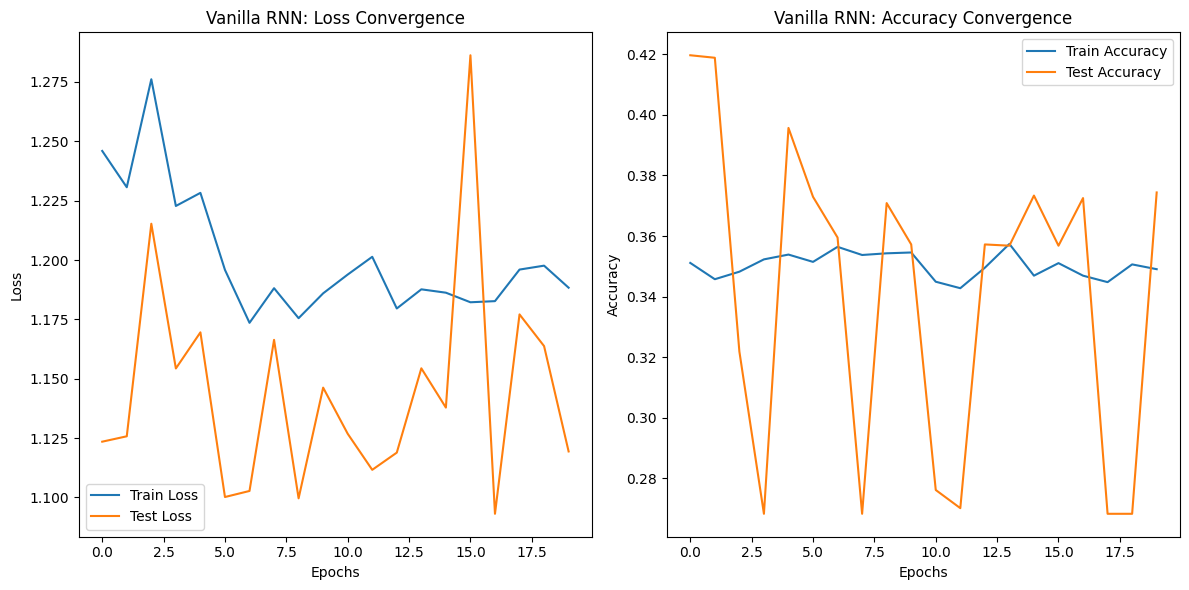

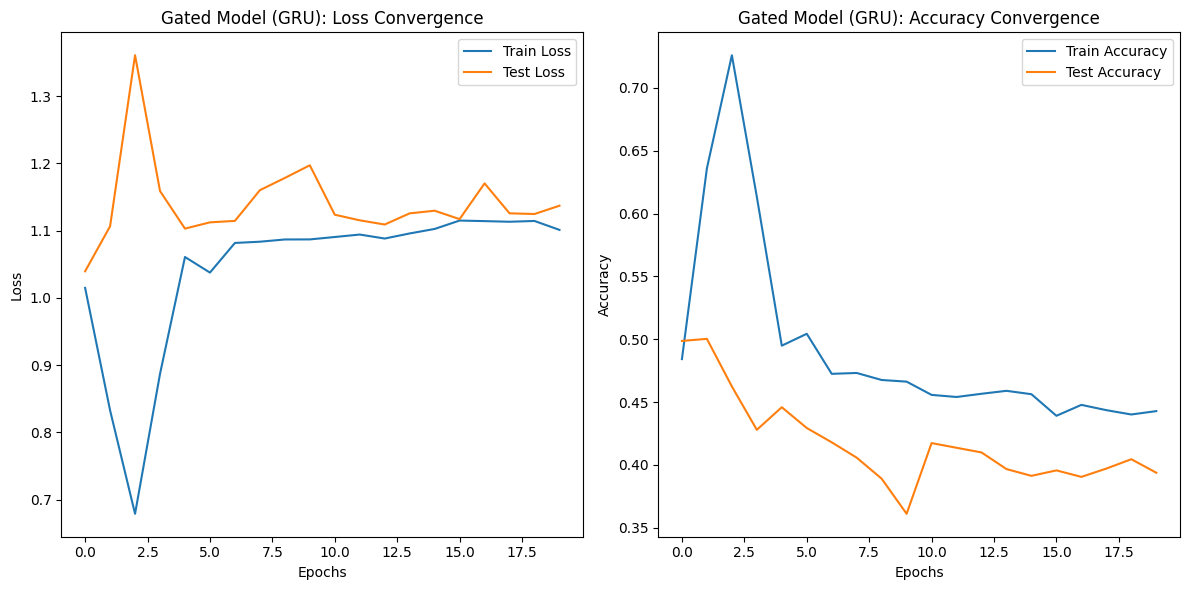

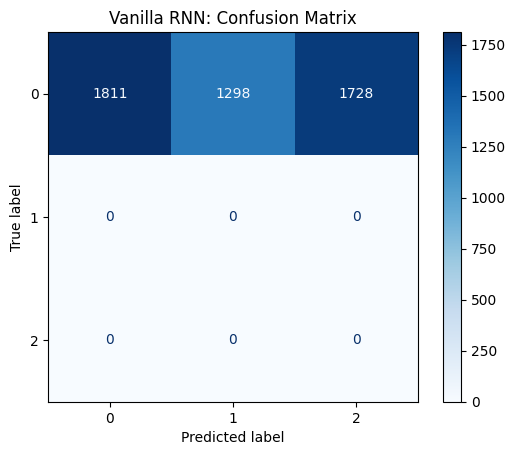

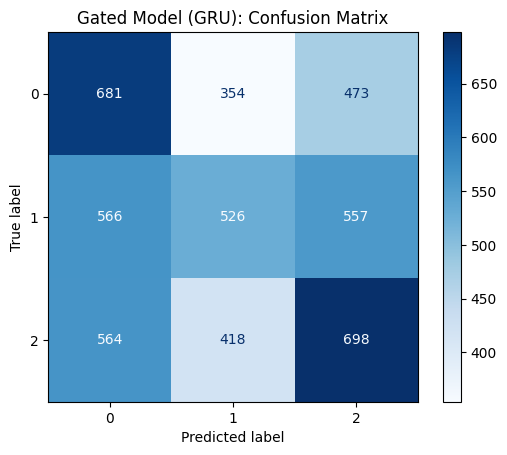

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np

# Load the processed data
train_data = pd.read_csv("processed_train_data.csv")
test_data = pd.read_csv("processed_test_data.csv")
vocab = torch.load("vocab.pth")

# Create a custom dataset
class EmotionDataset(Dataset):
    def __init__(self, indices, labels):
        self.indices = indices
        self.labels = labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return torch.tensor(self.indices[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = EmotionDataset(train_data['indices'].apply(eval).tolist(), train_data['label'].tolist())
test_dataset = EmotionDataset(test_data['indices'].apply(eval).tolist(), test_data['label'].tolist())

# Define custom collate function to handle padding
def collate_fn(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence([torch.tensor(text, dtype=torch.long) for text in texts],
                                batch_first=True, padding_value=vocab["<PAD>"])
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_texts, labels

# Update DataLoader to use the custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Define the models
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        hidden = self.dropout(hidden)
        out = self.fc(hidden.squeeze(0))
        return out

class GatedModel(nn.Module):  # GRU or LSTM
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(GatedModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.gru(x)
        hidden = self.dropout(hidden)
        out = self.fc(hidden.squeeze(0))
        return out

# Initialize models
embed_size = 50
hidden_size = 128
num_classes = len(train_data['label'].unique())
vocab_size = len(vocab)

vanilla_model = VanillaRNN(vocab_size, embed_size, hidden_size, num_classes)
gated_model = GatedModel(vocab_size, embed_size, hidden_size, num_classes)

# Training function
def train_model(model, train_loader, test_loader, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Evaluation
        model.eval()
        total_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(predicted.tolist())
                all_labels.extend(labels.tolist())
        test_losses.append(total_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]*100:.2f}%, Test Acc: {test_accuracies[-1]*100:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies, all_preds, all_labels

# Train and evaluate models
num_epochs = 20
learning_rate = 0.01

print("\nTraining Vanilla RNN...")
vanilla_results = train_model(vanilla_model, train_loader, test_loader, num_epochs, learning_rate)

print("\nTraining Gated Model (GRU)...")
gated_results = train_model(gated_model, train_loader, test_loader, num_epochs, learning_rate)

# Function to plot results
def plot_results(train_losses, test_losses, train_accuracies, test_accuracies, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title(f"{title}: Loss Convergence")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.title(f"{title}: Accuracy Convergence")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot results for each model
plot_results(*vanilla_results[:-2], title="Vanilla RNN")
plot_results(*gated_results[:-2], title="Gated Model (GRU)")

# Confusion matrix for each model
def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{title}: Confusion Matrix")
    plt.show()

plot_confusion_matrix(*vanilla_results[-2:], title="Vanilla RNN")
plot_confusion_matrix(*gated_results[-2:], title="Gated Model (GRU)")

<h2> Final Hyperparameters </h2>

C:\Users\shaha\AppData\Local\Temp\ipykernel_19568\625143506.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vocab = torch.load("vocab.pth")



Training Vanilla RNN...


C:\Users\shaha\AppData\Local\Temp\ipykernel_19568\625143506.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text, dtype=torch.long) for text in texts],


Epoch 1/20, Train Loss: 1.1067, Test Loss: 1.1330, Train Acc: 37.16%, Test Acc: 26.71%
Epoch 2/20, Train Loss: 1.0963, Test Loss: 1.0903, Train Acc: 36.96%, Test Acc: 36.74%
Epoch 3/20, Train Loss: 1.0918, Test Loss: 1.0966, Train Acc: 37.46%, Test Acc: 36.37%
Epoch 4/20, Train Loss: 1.1176, Test Loss: 1.1036, Train Acc: 35.11%, Test Acc: 37.81%
Epoch 5/20, Train Loss: 1.1108, Test Loss: 1.0968, Train Acc: 35.39%, Test Acc: 41.99%
Epoch 6/20, Train Loss: 1.1125, Test Loss: 1.1080, Train Acc: 35.95%, Test Acc: 33.64%
Epoch 7/20, Train Loss: 1.1115, Test Loss: 1.0787, Train Acc: 36.58%, Test Acc: 43.21%
Epoch 8/20, Train Loss: 1.1040, Test Loss: 1.0906, Train Acc: 36.80%, Test Acc: 37.34%
Epoch 9/20, Train Loss: 1.1077, Test Loss: 1.0933, Train Acc: 36.49%, Test Acc: 39.80%
Epoch 10/20, Train Loss: 1.1043, Test Loss: 1.0900, Train Acc: 36.57%, Test Acc: 38.70%
Epoch 11/20, Train Loss: 1.1101, Test Loss: 1.0909, Train Acc: 36.33%, Test Acc: 37.03%
Epoch 12/20, Train Loss: 1.1078, Test Los

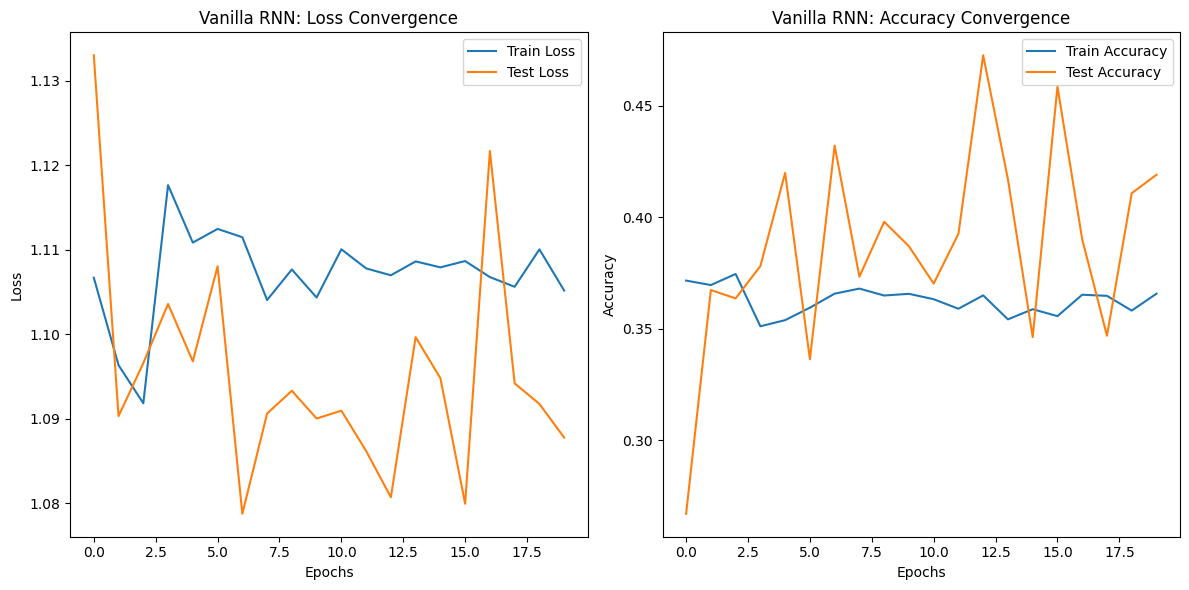

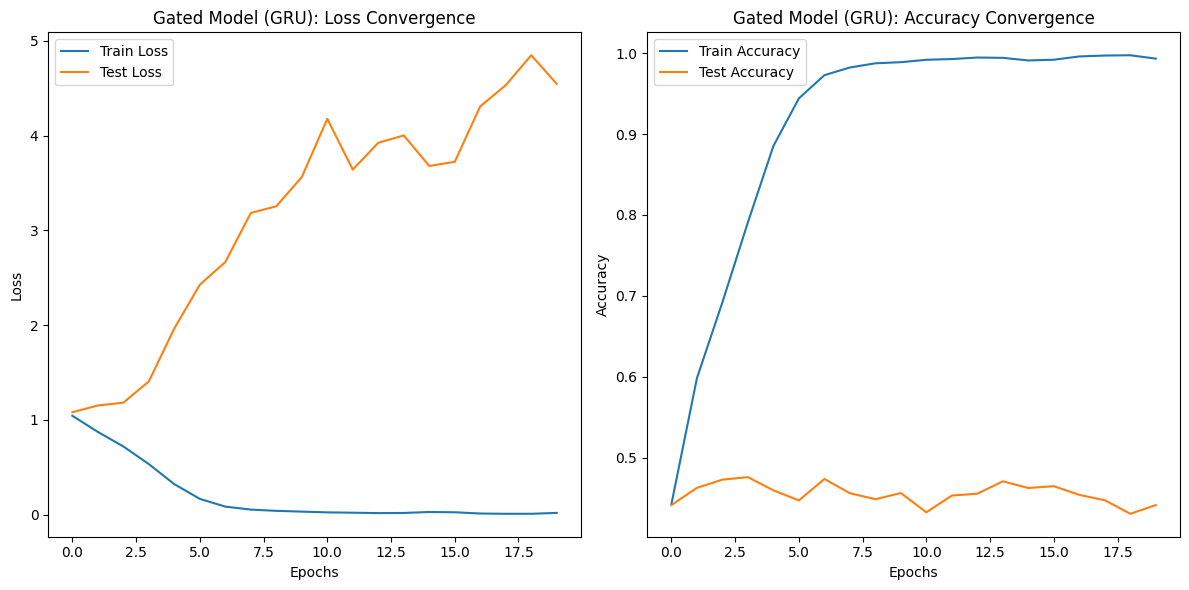

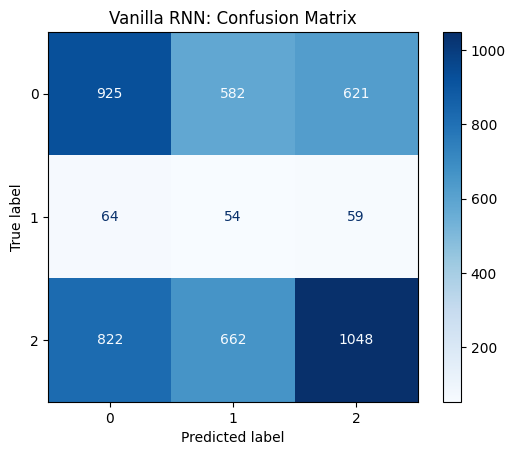

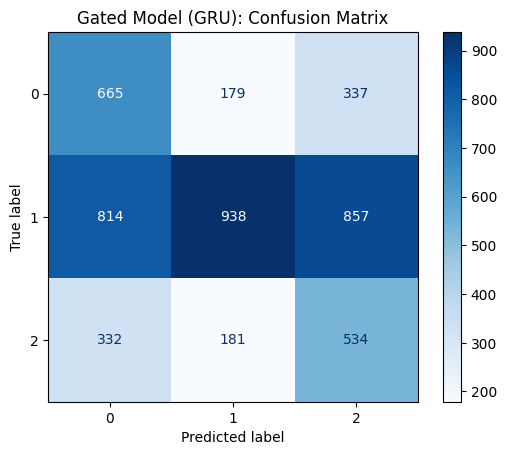

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np

# Load the processed data
train_data = pd.read_csv("processed_train_data.csv")
test_data = pd.read_csv("processed_test_data.csv")
vocab = torch.load("vocab.pth")

# Create a custom dataset
class EmotionDataset(Dataset):
    def __init__(self, indices, labels):
        self.indices = indices
        self.labels = labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return torch.tensor(self.indices[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = EmotionDataset(train_data['indices'].apply(eval).tolist(), train_data['label'].tolist())
test_dataset = EmotionDataset(test_data['indices'].apply(eval).tolist(), test_data['label'].tolist())

# Define custom collate function to handle padding
def collate_fn(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence([torch.tensor(text, dtype=torch.long) for text in texts],
                                batch_first=True, padding_value=vocab["<PAD>"])
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_texts, labels

# Update DataLoader to use the custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Define the models
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        hidden = self.dropout(hidden)
        out = self.fc(hidden.squeeze(0))
        return out

class GatedModel(nn.Module):  # GRU or LSTM
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(GatedModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.gru(x)
        hidden = self.dropout(hidden)
        out = self.fc(hidden.squeeze(0))
        return out

# Initialize models
embed_size = 100
hidden_size = 256
num_classes = len(train_data['label'].unique())
vocab_size = len(vocab)

vanilla_model = VanillaRNN(vocab_size, embed_size, hidden_size, num_classes)
gated_model = GatedModel(vocab_size, embed_size, hidden_size, num_classes)

# Training function
def train_model(model, train_loader, test_loader, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Evaluation
        model.eval()
        total_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(predicted.tolist())
                all_labels.extend(labels.tolist())
        test_losses.append(total_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]*100:.2f}%, Test Acc: {test_accuracies[-1]*100:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies, all_preds, all_labels

# Train and evaluate models
num_epochs = 20
learning_rate = 0.001

print("\nTraining Vanilla RNN...")
vanilla_results = train_model(vanilla_model, train_loader, test_loader, num_epochs, learning_rate)

print("\nTraining Gated Model (GRU)...")
gated_results = train_model(gated_model, train_loader, test_loader, num_epochs, learning_rate)

# Function to plot results
def plot_results(train_losses, test_losses, train_accuracies, test_accuracies, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title(f"{title}: Loss Convergence")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.title(f"{title}: Accuracy Convergence")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot results for each model
plot_results(*vanilla_results[:-2], title="Vanilla RNN")
plot_results(*gated_results[:-2], title="Gated Model (GRU)")

# Confusion matrix for each model
def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{title}: Confusion Matrix")
    plt.show()

plot_confusion_matrix(*vanilla_results[-2:], title="Vanilla RNN")
plot_confusion_matrix(*gated_results[-2:], title="Gated Model (GRU)")

<h2>Discussion on Code Comparison</h2>

<h3>1. Differences in Hyperparameters</h3>
<p>
The key differences between the <span class="highlight">first code block</span> and the <span class="highlight">second code block</span> lie in their choice of hyperparameters, such as <span class="highlight">dropout rate, learning rate, embedding size, hidden size</span>, and <span class="highlight">number of epochs</span>. These differences significantly impact model performance, as explained below:
</p>
<ul>
    <li>
        <span class="highlight">Dropout Rate:</span> 
        The <span class="highlight">first code block</span> uses a <span class="difference">dropout rate of 0.5</span>, compared to <span class="difference">0.3</span> in the <span class="highlight">second code block</span>. The higher dropout rate in the first code block helps reduce overfitting, especially for the GRU model.
    </li>
    <li>
        <span class="highlight">Learning Rate:</span> 
        The <span class="highlight">first code block</span> uses a <span class="difference">learning rate of 0.01</span>, while the <span class="highlight">second code block</span> has a <span class="difference">learning rate of 0.001</span>. The higher learning rate in the first code block results in faster convergence but can lead to instability or suboptimal solutions.
    </li>
    <li>
        <span class="highlight">Embedding Size:</span> 
        The <span class="highlight">second code block</span> uses an <span class="difference">embedding size of 100</span>, compared to <span class="difference">50</span> in the <span class="highlight">first code block</span>. The larger embedding size in the second code block allows for richer word representations.
    </li>
    <li>
        <span class="highlight">Hidden Size:</span> 
        The <span class="highlight">second code block</span> has a <span class="difference">hidden size of 256</span>, compared to <span class="difference">128</span> in the <span class="highlight">first code block</span>. A larger hidden size enables the model to capture more complex patterns but increases the risk of overfitting.
    </li>
    <li>
        <span class="highlight">Number of Epochs:</span> 
        The <span class="highlight">first code block</span> trains for <span class="difference">10 epochs</span>, while the <span class="highlight">second code block</span> trains for <span class="difference">20 epochs</span>. The second code block's longer training allows the models to better learn the data, but it may overfit.
    </li>
</ul>

<h3>2. Impact on Model Performance</h3>
<p>
The differences in hyperparameters:
</p>
<ul>
    <li>
        The <span class="highlight">higher dropout rate</span> in the first code block improves generalization, reducing overfitting, especially for the GRU model.
    </li>
    <li>
        The <span class="highlight">higher learning rate</span> in the first code block accelerates training but results in less stable training dynamics, as seen in the fluctuating accuracy for the Vanilla RNN.
    </li>
    <li>
        The <span class="highlight">larger embedding size</span> and <span class="highlight">hidden size</span> in the second code block provide more capacity for capturing intricate relationships in the data, which is beneficial for complex datasets.
    </li>
    <li>
        Training for <span class="highlight">fewer epochs</span> in the first code block helps prevent overfitting, but the GRU's performance plateaus at around 47% test accuracy, showing limited improvement due to insufficient training.
    </li>
</ul>

<h2>Discussion on Model Comparison</h2>

<h3>1. Vanilla RNN</h3>
<p>
The <span class="highlight">Vanilla RNN</span> is a simple recurrent model that processes sequential data by passing the hidden state from one time step to the next. The main strength of this model lies in its simplicity and computational efficiency. However, it suffers from the following limitations:
</p>
<ul>
    <li>
        <span class="highlight">Vanishing Gradient Problem:</span> Vanilla RNN struggles to retain information over long sequences due to the exponential decay of gradients during backpropagation, making it difficult to capture long-term dependencies.
    </li>
    <li>
        <span class="highlight">Limited Memory:</span> The single hidden state used in Vanilla RNNs is not sufficient to store all the necessary information, especially in complex datasets requiring contextual understanding.
    </li>
</ul>
<p>
Despite these limitations, Vanilla RNN is often a good starting point for sequence-based tasks and performs well on simpler datasets or problems where long-term dependencies are not critical.
</p>

<h3>2. Gated Recurrent Unit (GRU)</h3>
<p>
The <span class="highlight">GRU</span> is a more advanced recurrent model designed to address the limitations of Vanilla RNNs. GRU introduces two gates—<span class="highlight">update gate</span> and <span class="highlight">reset gate</span>—to control the flow of information through the network. These gates allow the model to selectively retain or discard information, improving its ability to capture long-term dependencies. Key features of GRU include:
</p>
<ul>
    <li>
        <span class="highlight">Efficient Memory Retention:</span> GRU uses gates to retain important information over longer time horizons, making it suitable for tasks requiring contextual understanding of sequences.
    </li>
    <li>
        <span class="highlight">Fewer Parameters than LSTM:</span> Compared to LSTMs, GRUs have fewer parameters because they combine the forget and input gates into a single update gate, making them computationally less expensive while retaining similar capabilities.
    </li>
</ul>
<p>
GRU models often outperform Vanilla RNNs on complex sequence-based tasks, especially where long-term dependencies are crucial, such as in text and time-series data.
</p>

<h3>3. Comparison Between Vanilla RNN and GRU</h3>
<p>
The key differences between Vanilla RNN and GRU models are summarized below:
</p>
<ul>
    <li>
        <span class="highlight">Information Flow:</span> Vanilla RNN propagates information through a single hidden state, whereas GRU uses gating mechanisms to control the flow of information, enabling it to handle long-term dependencies better.
    </li>
    <li>
        <span class="highlight">Gradient Issues:</span> Vanilla RNN is prone to vanishing gradient problems, which limits its ability to learn from long sequences. GRU alleviates this issue by using gates to retain gradients more effectively.
    </li>
    <li>
        <span class="highlight">Task Suitability:</span> Vanilla RNN is more suitable for simpler tasks where sequence dependencies are short or not complex, while GRU excels in tasks requiring deeper contextual understanding and longer memory.
    </li>
    <li>
        <span class="highlight">Computational Complexity:</span> GRU is computationally more expensive than Vanilla RNN but less so than LSTM, making it a good balance for tasks requiring moderate computational resources.
    </li>
</ul>

<h3>4. Summary</h3>
<p>
The Vanilla RNN provides a lightweight and efficient solution for simpler sequence tasks but suffers from limited memory capacity and vanishing gradients. GRU, on the other hand, is more robust for complex tasks, offering better handling of long-term dependencies through its gating mechanisms. The choice between the two models depends on the complexity of the task and the computational resources available.
</p>

</body>
</html>


